# Test notebook

Mhamed JABRI and Oscar CLIVIO

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist
from scipy.stats import norm, chi2

from Kmeans import KMeans
from EM_GaussianMixture import EM_GMM

In [2]:
data = pd.read_csv('./classification_data_HWK2/EMGaussian.data', sep=" ", header=None)
data_test = pd.read_csv('./classification_data_HWK2/EMGaussian.test', sep=" ", header=None)

X = data.copy()

# 1. KMeans

In [3]:
clf1 = KMeans(k=4, random_seed=17, init='generic')
clf2 = KMeans(k=4, random_seed=7, init='generic')
clf3 = KMeans(k=4, random_seed=1, init='generic')
clf4 = KMeans(k=4, random_seed=42, init='kmeans++')

clf1.fit(np.array(data))
clf2.fit(np.array(data))
clf3.fit(np.array(data))
clf4.fit(np.array(data))

X['generic_init_seed17'] = clf1.labels 
X['generic_init_seed7'] = clf2.labels 
X['generic_init_seed1'] = clf3.labels 
X['kmeans++_init_seed42'] = clf4.labels 

## Distortion measure at convergence for each model 

In [4]:
models = [clf1, clf2, clf3, clf4]
models_names = ['random_init1','random_init2','random_init3','init_kmeans++']

for model, name_of_model in zip(models, models_names) : 
    print("Distortion for " +name_of_model+' : ', round(model.compute_distortion(np.array(data)),2))

Distortion for random_init1 :  3240.59
Distortion for random_init2 :  3237.72
Distortion for random_init3 :  3237.78
Distortion for init_kmeans++ :  3237.67


## Number of iterations needed before convergence of KMeans

In [5]:
for model, name_of_model in zip(models, models_names) : 
    print("Number of iterations before convergence for " +name_of_model+' : ', model.iterations_before_cv)

Number of iterations before convergence for random_init1 :  15
Number of iterations before convergence for random_init2 :  8
Number of iterations before convergence for random_init3 :  22
Number of iterations before convergence for init_kmeans++ :  4


## Difference between centers for different initializations

In [6]:
centers_1 = np.sort(clf1.centers, axis=0)
centers_2 = np.sort(clf2.centers, axis=0)
centers_3 = np.sort(clf3.centers, axis=0)
centers_4 = np.sort(clf4.centers, axis=0)

distances=list()
for j in range(4):
    centers_models =normalize(np.array([centers_1[j],centers_2[j],centers_3[j],centers_4[j]]), norm='l2')
    distances.append(max(pdist(centers_models)))
    print("Maximum distance between normalized centers of clusters "+str(j)+": ", round(distances[j],3))

Maximum distance between normalized centers of clusters 0:  0.002
Maximum distance between normalized centers of clusters 1:  0.062
Maximum distance between normalized centers of clusters 2:  0.04
Maximum distance between normalized centers of clusters 3:  0.008


## Plot clusters and centers

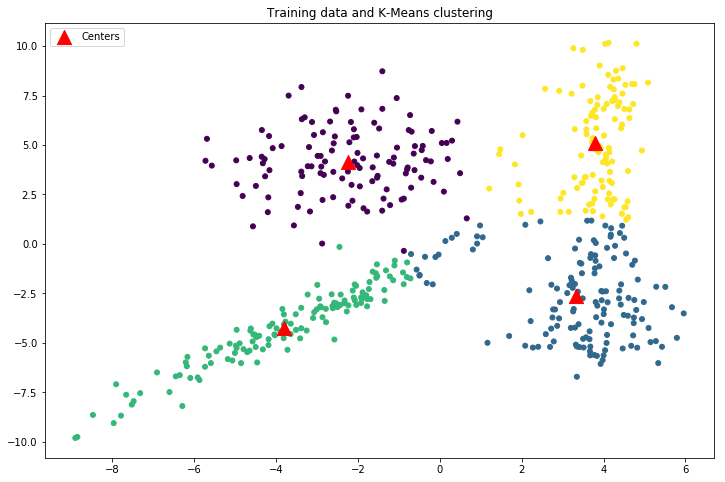

In [7]:
plt.figure(figsize=(12,8))
plt.scatter(data[0], data[1], c=X['kmeans++_init_seed42'], marker='o', s=25, label=None)
plt.scatter(clf3.centers[:,0], clf3.centers[:,1], color="red", marker="^", s=200, label="Centers")
plt.title("Training data and K-Means clustering")
plt.legend()
plt.savefig("K-Means.png",bbox_inches='tight')
plt.show();

# 2. EM for Gaussian Mixture Models

In [8]:
clf_em_iso = EM_GMM(k=4, init='kmeans', epsilon=1e-3,  format_covariance='isotropic', random_seed=17)
clf_em_general_km = EM_GMM(4, init='kmeans', epsilon=1e-3, format_covariance='general', random_seed=17)
clf_em_general_rd = EM_GMM(4, init='random', epsilon=1e-3, format_covariance='general', random_seed=7)

clf_em_iso.fit(np.array(data))
clf_em_general_km.fit(np.array(data))
clf_em_general_rd.fit(np.array(data))

labels_em_iso = clf_em_iso.predict(np.array(data))
labels_em_gen_km = clf_em_general_km.predict(np.array(data))
labels_em_gen_rd = clf_em_general_rd.predict(np.array(data))

In [9]:
def draw_ellipse(position, covariance, color_ellipse, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the ellipses containing 68% and 95% of the data using standard deviation 
    for nsig in range(1, 3):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, color = color_ellipse,**kwargs))


def plot_gmm(gmm, X, label=True, ax=None):
    "takes in argument gmm, a fitted model of the class EM_GMM"
    ax = ax or plt.gca()
    labels = gmm.predict(X)
    cdict = {0:'purple', 1: 'red', 2: 'blue', 3: 'green'}
    col_ellipses = {0:'darkmagenta', 1: 'maroon', 2: 'royalblue', 3: 'darkgreen'}

    if label:
        for g in range(4) : 
            ix = np.where(labels == g)
            ax.scatter(X[ix][:,0], X[ix][:,1], c = cdict[g], s = 30, zorder=2)
        ax.scatter(gmm.mu[:,0], gmm.mu[:,1], color="k", marker="^", s=200, zorder=3, label="Centers")

    ax.axis('equal')
    

    
    w_factor = 0.2 / np.array(gmm.pi).max()
    for pos, covar, w, col in zip(gmm.mu, gmm.sigma, gmm.pi, list(col_ellipses.values())):
        draw_ellipse(pos, covar, col, alpha=w * w_factor)

## Assumption of covariance matrices proportional to the identity

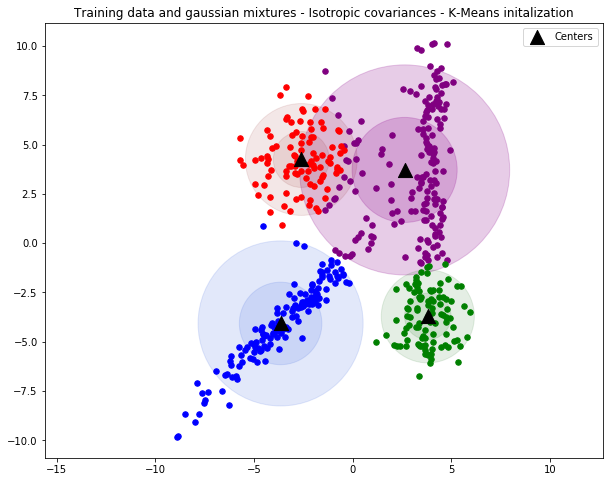

In [10]:
plt.figure(figsize=(10,8))
plot_gmm(clf_em_iso, np.array(data), label=True, ax=None)
plt.legend()
plt.title("Training data and gaussian mixtures - Isotropic covariances - K-Means initalization")
plt.savefig("GMM_isotropic.png",bbox_inches='tight')
plt.show();

## Assumption of general covariance matrices to the identity

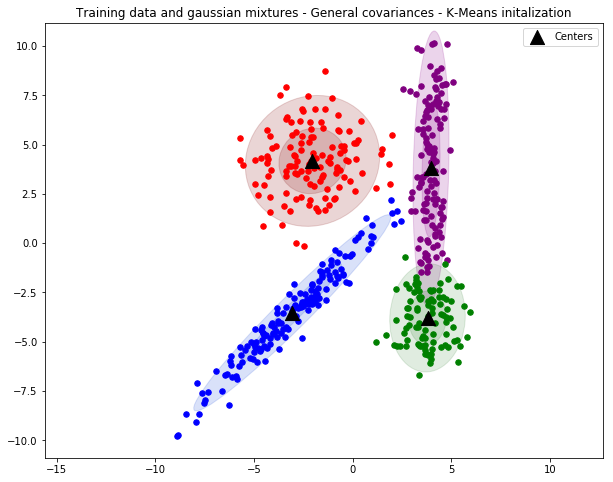

In [11]:
plt.figure(figsize=(10,8))
plot_gmm(clf_em_general_km, np.array(data), label=True, ax=None)
plt.legend()
plt.title("Training data and gaussian mixtures - General covariances - K-Means initalization")
plt.savefig("GMM_general.png",bbox_inches='tight')
plt.show();

## Comparing likelihoods at convergence under both assumptions

In [12]:
print("----------------------TRAIN SET--------------------")
print("log likelihood for the training set at convergence (spherical covariance) : ", round(clf_em_iso._compute_complete_likelihood(np.array(data)),2))
print("log likelihood for the training set at convergence (general covariance and uniform init) : ", round(clf_em_general_rd._compute_complete_likelihood(np.array(data)),2))
print("log likelihood for the training set at convergence (general covariance and kmeans init) : ", round(clf_em_general_km._compute_complete_likelihood(np.array(data)),2))

print("----------------------TEST SET--------------------")
print("log likelihood for the test set at convergence (spherical covariance) : ", round(clf_em_iso._compute_complete_likelihood(np.array(data_test)),2))
print("log likelihood for the training set at convergence (general covariance and uniform init) : ", round(clf_em_general_rd._compute_complete_likelihood(np.array(data_test)),2))
print("log likelihood for the test set at convergence (general covariance and kmeans init) : ", round(clf_em_general_km._compute_complete_likelihood(np.array(data_test)),2))


----------------------TRAIN SET--------------------
log likelihood for the training set at convergence (spherical covariance) :  -2639.57
log likelihood for the training set at convergence (general covariance and uniform init) :  -2383.19
log likelihood for the training set at convergence (general covariance and kmeans init) :  -2327.72
----------------------TEST SET--------------------
log likelihood for the test set at convergence (spherical covariance) :  -2614.59
log likelihood for the training set at convergence (general covariance and uniform init) :  -2501.74
log likelihood for the test set at convergence (general covariance and kmeans init) :  -2409.05
